# Hazma Example Model

## Overview

In this notebook, we demonstrate how to construct a user-defined model in ``hazma``. The model we will consider is an effective field theory with a Dirac fermion DM particle which talks to neutral and charged pions through gauge-invariant dimension-5 operators. The Lagrangian for this model is:

\begin{align}
    \mathcal{L} &\supset \dfrac{c_1}{\Lambda}\overline{\chi}\chi\pi^{+}\pi^{-} + \dfrac{c_2}{\Lambda}\overline{\chi}\chi\pi^{0}\pi^{0}
\end{align}

where $c_{1}, c_{2}$ are dimensionless Wilson coefficients and $\Lambda$ is the cut-off scale of the theory. In order to implement this model in ``hazma``, we need to compute the annihilation cross sections and the FSR spectra. The annihilation channels for this model are simply $\bar{\chi}\chi\to\pi^{0}\pi^{0}$ and $\bar{\chi}\chi\to\pi^{+}\pi^{-}$. The computations for the cross sections are straight forward and yield:

\begin{align}
    \sigma(\bar{\chi}\chi\to\pi^{+}\pi^{-}) &= \frac{c_1^2 \sqrt{1-4 \mu _{\pi }^2} \sqrt{1-4 \mu _{\chi }^2}}{32 \pi \Lambda^2}\\
    \sigma(\bar{\chi}\chi\to\pi^{0}\pi^{0}) &= \frac{c_2^2 \sqrt{1-4 \mu_{\pi^{0}}^2} \sqrt{1-4 \mu_{\chi}^2}}{8 \pi \Lambda^2}
\end{align}

where \(Q\) is the center of mass energy, \(\mu_{\chi} = m_{\chi}/Q\), \(\mu_{\pi} = m_{\pi^{\pm}}/Q\) and \(\mu_{\pi^{0}} = m_{\pi^{0}}/Q\). In addition to the cross sections, we need the FSR spectrum for \(\overline{\chi}\chi\to\pi^{+}\pi^{-}\gamma\). This is:

\begin{align}
    \dfrac{dN(\bar{\chi}\chi\to\pi^{+}\pi^{-}\gamma)}{dE_{\gamma}} &= \frac{\alpha  \left(2 f(x)-2\left(1-x-2 \mu_{\pi} ^2\right)
   \log \left(\frac{1-x-f(x)}{1-x+f(x)}\right)\right)}{\pi  \sqrt{1-4 \mu_{\pi} ^2} x}
\end{align}

where 

\begin{align}
    f(x) &= \sqrt{1-x} \sqrt{1-x-4 \mu_{\pi} ^2}
\end{align}

Below we will demonstrate how we think a user should implement a model.

## Imports

There are various packages that we will be using throughout the notebook:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from hazma.parameters import neutral_pion_mass as mpi0
from hazma.parameters import charged_pion_mass as mpi
from hazma.parameters import electron_mass as me
from hazma.parameters import qe

from hazma.positron_spectra import charged_pion as pspec_charged_pion
from hazma.decay import neutral_pion, charged_pion

from hazma.theory import Theory
from hazma.gamma_ray_parameters import (energy_res_fermi, energy_res_e_astrogam,
                                        A_eff_e_astrogam, A_eff_comptel,
                                        egret_diffuse, fermi_diffuse,
                                        comptel_diffuse, gc_target,
                                        gc_bg_model, solid_angle)

# We will ignore warnings since they aren't important for this example
import warnings
warnings.filterwarnings('ignore')

## Defining the model

As described in the paper, we will be be defined the model using mixin classes. For ``hazma`` to work properly, we will need to define the following functions in our model:

1. ``annihilation_cross_sections(cme)``: A function returning a dictionary of the annihilation cross sections for a given center of mass energy.
2. ``annihilation_branching_fractions(cme)``: A function returning a dictionary of the annihilation branching fractions for a given center of mass energy.
3. ``gamma_ray_lines(cme)``: A function returning a dictionary of the gamma-ray lines for a given center of mass energy.
4. ``spectra(e_gams, cme)``: A function returning a dictionary of the continuum gamma-ray spectra for a given photon and center of mass energy.
5. ``positron_spectra(e_ps, e_cm)``: A function returning a dictionary of the continuum electron/positron spectra for a given positron and center of mass energy.
6. ``positron_lines(e_cm)``: A function returning a dictionary of the electron/positron lines for a center of mass energy.

We will assume that the master class contains the following attributes:

1. $m_{\chi}$: the DM mass,
2. $c_{1}$: the Wilson coefficient of first effective operator,
3. $c_{2}$: the Wilson coefficient of second effective operator,
5. $\Lambda$: the cut-off scale of the effective theory.

First, we implement cross section class. 

In [2]:
class HazmaExampleCrossSection:
    
    def sigma_xx_to_pipi(self, Q):
        mupi = mpi / Q
        mux = self.mx / Q

        if Q > 2 * self.mx and Q > 2 * mpi:
            sigma = (self.c1**2 * np.sqrt(1 - 4 * mupi**2) * 
                     np.sqrt(1 - 4 * mux**2)**2 / 
                     (32.0 * self.lam**2 * np.pi))
        else:
            sigma = 0.0

        return sigma

    def sigma_xx_to_pi0pi0(self, Q):
        mupi0 = mpi0 / Q
        mux = self.mx / Q

        if Q > 2 * self.mx and Q > 2 * mpi0:
            sigma = (self.c2**2 * np.sqrt(1 - 4 * mux**2) *
                     np.sqrt(1 - 4 * mupi0**2) /
                     (8.0 * self.lam**2 * np.pi))
        else:
            sigma = 0.0

        return sigma
    
    def annihilation_cross_sections(self, Q):
        pipi = self.sigma_xx_to_pipi(Q)
        pi0pi0 = self.sigma_xx_to_pi0pi0(Q)
        
        total = pipi + pi0pi0
        
        return {'pi0 pi0': pi0pi0,
                'pi pi': pipi,
                'total': total}
        
    def annihilation_branching_fractions(self, Q):
        css = self.annihilation_cross_sections(Q)
        brs = {key: 0.0 for key in css.keys()}
        
        if css['total'] > 0.0:
            for key in brs.keys():
                brs[key] = css[key] / css['total']
        
        del brs['total']

        return brs

Next, we implement the FSR spectrum for $\bar{\chi}\chi\to\pi^{+}\pi^{-}$:

In [3]:
class HazmaExampleFSR:
    
    def __dnde_xx_to_pipig(self, eng_gam, Q):
        mupi = mpi / Q
        mux = self.mx / Q
        x = 2.0 * eng_gam / Q
        if 0.0 < x and x < 1. - 4. * mupi**2:
            dnde = ((qe**2 * (2 * np.sqrt(1 - x) * np.sqrt(1 - 4*mupi**2 - x) + 
                          (-1 + 2 * mupi**2 + x) * 
                          np.log((-1 + np.sqrt(1 - x) * np.sqrt(1 - 4*mupi**2 - x) + x)**2/
                                 (1 + np.sqrt(1 - x)*np.sqrt(1 - 4*mupi**2 - x) - x)**2)))/
                (Q * 2.0 * np.sqrt(1 - 4 * mupi**2) * np.pi**2 * x))
        else:
            dnde = 0
        
        return dnde
    
    def dnde_xx_to_pipig(self, eng_gams, Q):
        if hasattr(eng_gams, '__len__'):
            return np.array([self.__dnde_xx_to_pipig(eng_gam, Q)
                             for eng_gam in eng_gams])
        else:
            return self.__dnde_xx_to_pipig(eng_gams, Q)     

Now we define the positron/electron spectra from $\bar{\chi}\chi\to\pi^{+}\pi^{-}$ (note that $\bar{\chi}\chi\to\pi^{0}\pi^{0}$ does not contribute to the positron spectrum.)

In [4]:
class HazmaExamplePositronSpectra:
    
    def dnde_pos_pipi(self, eng_ps, cme):
        return pspec_charged_pion(eng_ps, cme / 2.)
    
    def positron_spectra(self, eng_ps, cme):
        
        bfs = self.annihilation_branching_fractions(cme)

        # Only compute the spectrum if the channel's branching fraction is
        # nonzero
        def spec_helper(bf, specfn):
            if bf != 0:
                return bf * specfn(eng_ps, cme)
            else:
                return np.zeros(eng_ps.shape)

        pipi_spec = spec_helper(bfs['pi pi'], self.dnde_pos_pipi)

        return {"total": pipi_spec, "pi pi": pipi_spec}

    def positron_lines(self, cme):
        return {}

The last mixin we will define in the total spectrum class. This class will implement the total gamma-ray spectrum from both $\bar{\chi}\chi\to\pi^{+}\pi^{-}$ and $\bar{\chi}\chi\to\pi^{0}\pi^{0}$, including FSR and decays:

In [5]:
class HazmaExampleSpectra:
    
    def dnde_pi0pi0(self, e_gams, e_cm, spectrum_type='all'):
        return 2.0 * neutral_pion(e_gams, e_cm / 2.0)

    def dnde_pipi(self, e_gams, e_cm, spectrum_type='all'):
        return (self.dnde_xx_to_pipig(e_gams, e_cm) +
                2. * charged_pion(e_gams, e_cm / 2.0))
    
    def spectra(self, e_gams, e_cm):
        bfs = self.annihilation_branching_fractions(e_cm)
        
        def spec_helper(bf, specfn):
            if bf != 0:
                return bf * specfn(e_gams, e_cm)
            else:
                return np.zeros(e_gams.shape)

        # Pions
        npions = spec_helper(bfs['pi0 pi0'], self.dnde_pi0pi0)
        cpions = spec_helper(bfs['pi pi'], self.dnde_pipi)

        # Compute total spectrum
        total = npions + cpions

        # Define dictionary for spectra
        specs = {'total': total,
                 'pi0 pi0': npions,
                 'pi pi': cpions}

        return specs
    
    def spectrum_functions(self):
        return {'pi0 pi0': lambda e_gams, e_cm:
                    self.dnde_pi0pi0(e_gams, e_cm),
                'pi pi': lambda e_gams, e_cm:
                    self.dnde_pipi(e_gams, e_cm)}

    def gamma_ray_lines(self, e_cm):
        return {}

Lastly, we combine all the mixins into a master class. In the master class, we set the attributes of the model via and ``__init__``.

In [6]:
class HazmaExample(HazmaExampleCrossSection,
                   HazmaExampleFSR,
                   HazmaExamplePositronSpectra,
                   HazmaExampleSpectra,
                   Theory):
    def __init__(self, mx, c1, c2, lam):
        self.mx = mx
        self.c1 = c1
        self.c2 = c2
        self.lam = lam
    
    @classmethod
    def list_annihilation_final_states(cls):
        return ['pi pi', 'pi0 pi0']

## Computing Particle Physics Quantities

Now that we've defined our new model, we will demonstrate how to use it to compute various quantities. Let's define out model with the following parameters:

1. $m_{\chi} = 250 \ \mathrm{MeV}$
2. $c_{1} = 1.0$ 
3. $c_{2} = 1.0$ 
4. $\Lambda = 100 \ \mathrm{GeV}$ 

In [7]:
model = HazmaExample(mpi, 1.0, 1.0, 100e3)

### Gamma-ray Spectra

Below, we demonstrate how to compute the total gamma ray spectrum (as well as the sub components):

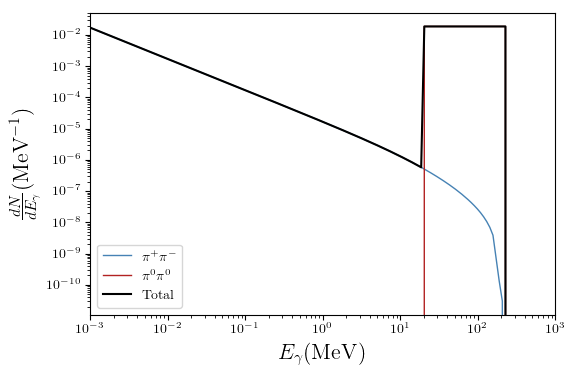

In [8]:
model.mx = 250.0

cme = 2.0 * model.mx * (1 + 0.5 * 1e-6)
photon_energies = np.logspace(-3.0, 3.0, num=150)
spectra = model.spectra(photon_energies, cme)

plt.figure(dpi=100)
plt.plot(photon_energies, spectra['pi pi'], label=r'$\pi^{+}\pi^{-}$', lw=1)
plt.plot(photon_energies, spectra['pi0 pi0'], label=r'$\pi^{0}\pi^{0}$',lw=1)
plt.plot(photon_energies, spectra['total'], label='Total', c='k')

plt.xlabel(r'$E_{\gamma} (\mathrm{MeV})$', fontsize=16)
plt.ylabel(r'$\frac{dN}{dE_{\gamma}} (\mathrm{MeV}^{-1})$', fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xlim([np.min(photon_energies), np.max(photon_energies)])
plt.legend()

### Positron Spectrum

(0.510998928, 1000.0)

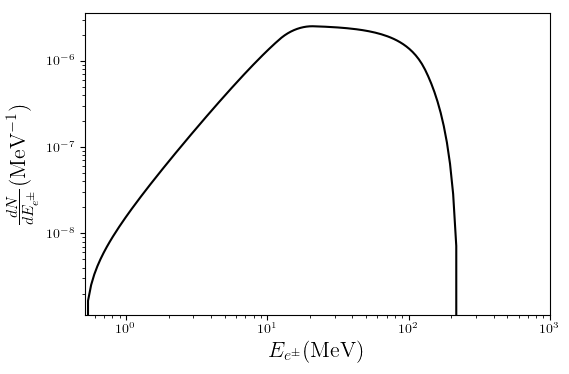

In [9]:
model.mx = 250.0
cme = 2.0 * model.mx * (1 + 0.5 * 1e-6)

positron_energies = np.logspace(np.log10(me), 3.0, num=150)
spectra = model.positron_spectra(positron_energies, cme)

plt.figure(dpi=100)
plt.plot(positron_energies, spectra['total'], c='k')

plt.xlabel(r'$E_{e^{\pm}} (\mathrm{MeV})$', fontsize=16)
plt.ylabel(r'$\frac{dN}{dE_{e^{\pm}}} (\mathrm{MeV}^{-1})$', fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xlim([np.min(positron_energies), np.max(positron_energies)])

### Annihilation Cross Sections and Branching Fractions

In [10]:
mxs = np.linspace(mpi0, 250., num=100)
bfs = {'pi pi': np.zeros_like(mxs), 'pi0 pi0': np.zeros_like(mxs)}
css = {'pi pi': np.zeros_like(mxs), 'pi0 pi0': np.zeros_like(mxs), 'total': np.zeros_like(mxs)}

for i, mx in enumerate(mxs):
    model.mx = mx
    cme = 2.0 * mx + mx * 1e-6
    
    _bfs = model.annihilation_branching_fractions(cme)
    bfs['pi pi'][i] = _bfs['pi pi']
    bfs['pi0 pi0'][i] = _bfs['pi0 pi0']
    
    _css = model.annihilation_cross_sections(cme)
    css['pi pi'][i] = _css['pi pi']
    css['pi0 pi0'][i] = _css['pi0 pi0']
    css['total'][i] = _css['total']

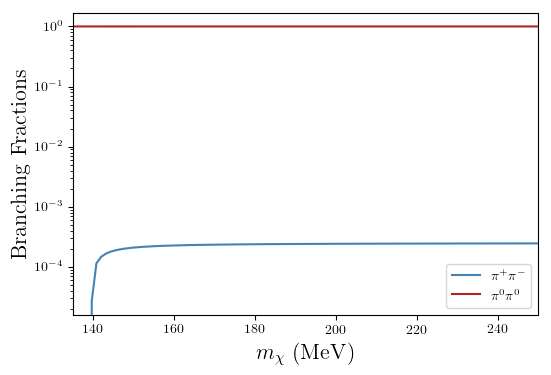

In [11]:
plt.figure(dpi=100)
plt.plot(mxs, bfs['pi pi'], label=r'$\pi^{+}\pi^{-}$')
plt.plot(mxs, bfs['pi0 pi0'], label=r'$\pi^{0}\pi^{0}$')
plt.yscale('log')
plt.ylabel(r'Branching Fractions',fontsize=16)
plt.xlabel(r'$m_{\chi} \ (\mathrm{MeV})$',fontsize=16)
plt.xlim([np.min(mxs),np.max(mxs)])
plt.legend()

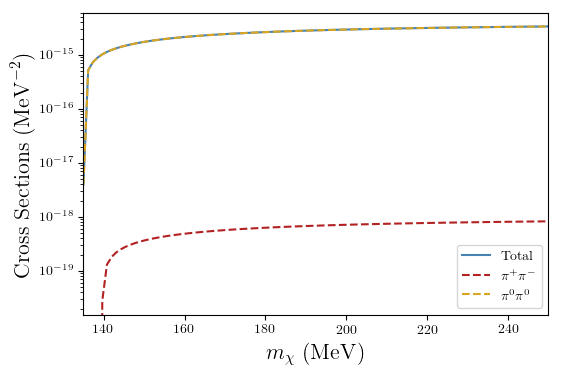

In [12]:
plt.figure(dpi=100)
plt.plot(mxs, css['total'], label=r'Total')
plt.plot(mxs, css['pi pi'], '--', label=r'$\pi^{+}\pi^{-}$')
plt.plot(mxs, css['pi0 pi0'], '--', label=r'$\pi^{0}\pi^{0}$')
plt.yscale('log')
plt.ylabel(r'Cross Sections $(\mathrm{MeV}^{-2})$',fontsize=16)
plt.xlabel(r'$m_{\chi} \ (\mathrm{MeV})$',fontsize=16)
plt.xlim([np.min(mxs),np.max(mxs)])
plt.legend()

### Limits on $\langle\sigma v\rangle$

Below we compute the limits on $\langle\sigma v\rangle$ from MeV gamma-ray telescopes. First, we use E-Astrogam

In [13]:
mxs = np.linspace(mpi0, 250., num=100)
limits = {'E-Astrogam': np.zeros_like(mxs), 'EGRET': np.zeros_like(mxs)}

for i, mx in enumerate(mxs):
    model.mx = mx
    limits['E-Astrogam'][i] = model.unbinned_limit(target_params=gc_target, bg_model=gc_bg_model)
    limits['EGRET'][i] = model.binned_limit(egret_diffuse)

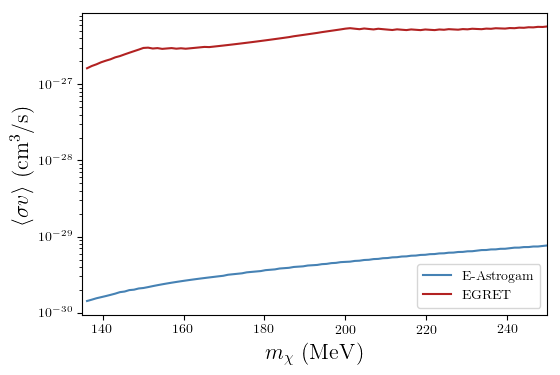

In [14]:
plt.figure(dpi=100)
plt.plot(mxs, limits['E-Astrogam'], label='E-Astrogam')
plt.plot(mxs, limits['EGRET'], label='EGRET')
plt.yscale('log')
plt.ylabel(r'$\langle\sigma v\rangle \ (\mathrm{cm}^3/\mathrm{s})$',fontsize=16)
plt.xlabel(r'$m_{\chi} \ (\mathrm{MeV})$',fontsize=16)
plt.xlim([np.min(mxs),np.max(mxs)])
plt.legend()